In [ ]:
import os
import zipfile
from google.colab import files

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# Untuk visualisasi dan evaluasi
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [ ]:
# --- Bagian Upload File ---
print("Silakan unggah file 'food_dataset.zip' Anda.")
uploaded = files.upload()

# Pastikan file yang diunggah bernama 'food_dataset.zip'
zip_file_name = "food_dataset.zip" # Nama file ZIP yang diharapkan
if zip_file_name not in uploaded:
    print(f"Error: File '{zip_file_name}' tidak ditemukan dalam file yang diunggah.")
    print(f"File yang terdeteksi: {list(uploaded.keys())}")
    # Hentikan eksekusi jika file tidak ditemukan
    raise SystemExit("Upload file gagal atau nama file tidak sesuai. Harap unggah ulang file ZIP yang benar.")
else:
    print(f"File '{zip_file_name}' berhasil diunggah.")

# --- Bagian Ekstraksi File ---
extract_to_dir = '/content/dataset' # Direktori tujuan untuk ekstraksi
if not os.path.exists(extract_to_dir):
    os.makedirs(extract_to_dir)
print(f"\nMengekstrak '{zip_file_name}' ke '{extract_to_dir}'...")
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)
print("Ekstraksi selesai.")

path_to_data = extract_to_dir


print(f"\nMemeriksa isi dari '{path_to_data}':")
try:
    print(os.listdir(path_to_data))
    if not all(folder in os.listdir(path_to_data) for folder in ['train', 'valid', 'test']):
        print(f"\nPERINGATAN: Folder 'train', 'valid', dan 'test' tidak ditemukan secara langsung di '{path_to_data}'.")
        print("Harap periksa struktur file ZIP Anda dan sesuaikan 'path_to_data' di atas.")
        print("Jika ZIP Anda memiliki folder induk, Anda harus menyertakannya dalam 'path_to_data'.")
        print("Contoh: path_to_data = os.path.join(extract_to_dir, 'NAMA_FOLDER_UTAMA_DALAM_ZIP')")
        print("Eksekusi akan tetap dilanjutkan, namun ImageDataGenerator mungkin gagal jika path salah.")
        # Anda bisa mengganti 'print' di atas dengan 'raise SystemExit(...)' jika ingin menghentikan paksa
except FileNotFoundError:
    print(f"Error: Direktori '{path_to_data}' tidak ditemukan. Pastikan ekstraksi berhasil dan 'path_to_data' benar.")
    raise SystemExit("Path ke data tidak valid.")


base_dir = path_to_data # Direktori yang berisi folder train, valid, test
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

print(f"\nPath yang akan digunakan:")
print(f"Direktori basis data: {base_dir}")
print(f"Direktori train: {train_dir}, Ada: {os.path.exists(train_dir)}")
print(f"Direktori valid: {validation_dir}, Ada: {os.path.exists(validation_dir)}")
print(f"Direktori test: {test_dir}, Ada: {os.path.exists(test_dir)}")

if not (os.path.exists(train_dir) and os.path.exists(validation_dir) and os.path.exists(test_dir)):
    print("\nError: Salah satu atau lebih direktori (train/valid/test) tidak ditemukan pada path yang ditentukan.")
    print("Pastikan variabel 'path_to_data' sudah benar dan proses ekstraksi berhasil.")
    raise SystemExit("Direktori dataset tidak valid.")
else:
    print("\nStruktur direktori dataset (train, valid, test) tampaknya benar.")

Silakan unggah file 'food_dataset.zip' Anda.


Saving food_dataset.zip to food_dataset.zip
File 'food_dataset.zip' berhasil diunggah.

Mengekstrak 'food_dataset.zip' ke '/content/dataset'...
Ekstraksi selesai.

Memeriksa isi dari '/content/dataset':
['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid', 'test']

Path yang akan digunakan:
Direktori basis data: /content/dataset
Direktori train: /content/dataset/train, Ada: True
Direktori valid: /content/dataset/valid, Ada: True
Direktori test: /content/dataset/test, Ada: True

Struktur direktori dataset (train, valid, test) tampaknya benar.


In [ ]:
# Sel 3: Persiapan Generator Data Gambar

IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Augmentasi data untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi nilai piksel ke [0,1]
    rotation_range=40,          # Rentang rotasi gambar (derajat)
    width_shift_range=0.2,      # Geser lebar gambar secara horizontal
    height_shift_range=0.2,     # Geser tinggi gambar secara vertikal
    shear_range=0.2,            # Pemotongan (shear)
    zoom_range=0.2,             # Zoom gambar
    horizontal_flip=True,       # Balik gambar secara horizontal
    fill_mode='nearest'         # Strategi pengisian piksel baru setelah transformasi
)

# Untuk validation dan test set, hanya rescale (normalisasi)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data
print("Membuat generator data training...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Karena ini masalah klasifikasi multikelas
    shuffle=True
)

print("\nMembuat generator data validasi...")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Tidak perlu di-shuffle untuk validasi
)

print("\nMembuat generator data testing...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Penting untuk evaluasi agar urutan tidak berubah
)

# Dapatkan jumlah kelas dan nama kelas
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"\nJumlah kelas makanan terdeteksi: {num_classes}")
print(f"Indeks kelas: {train_generator.class_indices}")
print(f"Nama kelas: {class_names}")

Membuat generator data training...
Found 1905 images belonging to 18 classes.

Membuat generator data validasi...
Found 178 images belonging to 18 classes.

Membuat generator data testing...
Found 89 images belonging to 18 classes.

Jumlah kelas makanan terdeteksi: 18
Indeks kelas: {'01. Ayam Betutu': 0, '02. Beberuk Terong': 1, '03. Coto Makassar': 2, '04. Gudeg': 3, '05. Kerak Telor': 4, '06. Mie Aceh': 5, '07. Nasi Kuning': 6, '08. Nasi Pecel': 7, '09. Papeda': 8, '10. Pempek': 9, '11. Peuyeum': 10, '12. Rawon': 11, '13. Rendang': 12, '14. Sate Madura': 13, '15. Serabi': 14, '16. Soto Banjar': 15, '17. Soto Lamongan': 16, '18. Tahu Sumedang': 17}
Nama kelas: ['01. Ayam Betutu', '02. Beberuk Terong', '03. Coto Makassar', '04. Gudeg', '05. Kerak Telor', '06. Mie Aceh', '07. Nasi Kuning', '08. Nasi Pecel', '09. Papeda', '10. Pempek', '11. Peuyeum', '12. Rawon', '13. Rendang', '14. Sate Madura', '15. Serabi', '16. Soto Banjar', '17. Soto Lamongan', '18. Tahu Sumedang']


In [ ]:
# Muat model MobileNetV2 pre-trained tanpa layer klasifikasi atas (include_top=False)
# dan dengan bobot dari ImageNet
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))

# Bekukan bobot dari base model agar tidak ikut terlatih di awal (penting untuk transfer learning)
base_model.trainable = False
print(f"\nBase model (MobileNetV2) trainable: {base_model.trainable}")

# Tambahkan layer kustom di atas base model
model = Sequential([
    base_model,                 # Model dasar yang sudah dilatih
    Flatten(),                  # Meratakan output dari base model
    Dense(256, activation='relu'), # Layer Dense terhubung penuh
    BatchNormalization(),       # Normalisasi batch untuk stabilitas training
    Dropout(0.5),               # Dropout untuk mengurangi overfitting
    Dense(num_classes, activation='softmax') # Layer output dengan aktivasi softmax untuk klasifikasi multikelas
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), # Optimizer Adam dengan learning rate awal
              loss='categorical_crossentropy',      # Loss function untuk klasifikasi multikelas
              metrics=['accuracy'])                 # Metrik untuk dipantau

# Tampilkan ringkasan model
print("\nRingkasan Model:")
model.summary()

<ipython-input-13-b7e2cd31b930>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet',



Base model (MobileNetV2) trainable: False

Ringkasan Model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,192,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,455,890 (39.89 MB)

 Trainable params: 8,197,394 (31.27 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [ ]:
EPOCHS = 30

# Callbacks untuk meningkatkan proses training
checkpoint_filepath = '/content/best_food_model.keras'

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

print("\nMemulai Training Model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Jumlah batch per epoch untuk training
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE, # Jumlah batch per epoch untuk validasi
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
    # Hapus 'workers=4' dan 'use_multiprocessing=True' dari sini
)
print("Training Selesai.")


Memulai Training Model...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_161']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4138 - loss: 2.1334
Epoch 1: val_accuracy improved from -inf to 0.72500, saving model to /content/best_food_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 388ms/step - accuracy: 0.4161 - loss: 2.1234 - val_accuracy: 0.7250 - val_loss: 0.9443 - learning_rate: 0.0010
Epoch 2/30
 1/59 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7188 - loss: 0.9282

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.72500
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7188 - loss: 0.9282 - val_accuracy: 0.7250 - val_loss: 0.9093 - learning_rate: 0.0010
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7596 - loss: 0.8040
Epoch 3: val_accuracy improved from 0.72500 to 0.73750, saving model to /content/best_food_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.7598 - loss: 0.8030 - val_accuracy: 0.7375 - val_loss: 0.8221 - learning_rate: 0.0010
Epoch 4/30
 1/59 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7500 - loss: 0.8207
Epoch 4: val_accuracy improved from 0.73750 to 0.75000, saving model to /content/best_food_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7500 - loss: 0.8207 - val_accuracy: 0.7500 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8223 - loss: 0.5969
Epoch 5: val_accuracy improved from 0.75000 to 0.76875, saving 


Memuat model terbaik untuk evaluasi (jika EarlyStopping digunakan dengan restore_best_weights=True)...


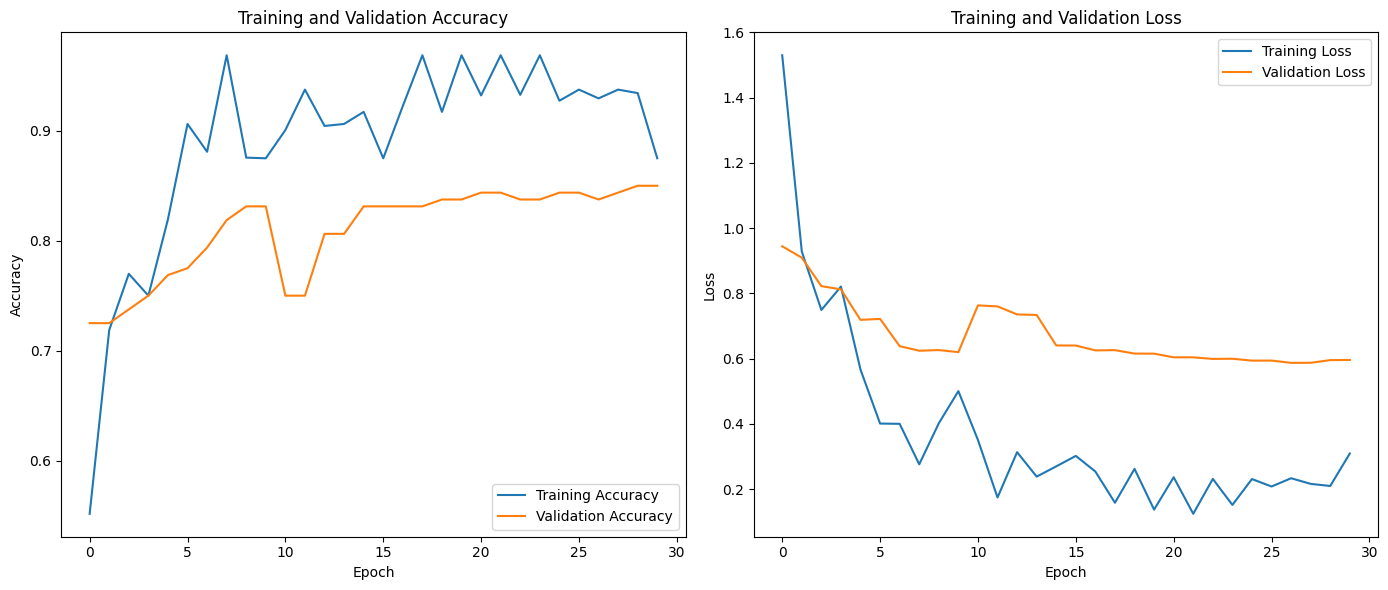


Evaluasi Model pada Test Set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8588 - loss: 0.4680
Test Loss: 0.4962
Test Accuracy: 0.8427

Melakukan prediksi pada Test Set untuk laporan detail...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_161']
Received: inputs=Tensor(shape=(32, 150, 150, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

Laporan Klasifikasi (Classification Report):
                    precision    recall  f1-score   support

   01. Ayam Betutu       1.00      0.75      0.86         8
02. Beberuk Terong       0.80      1.00      0.89         4
 03. Coto Makassar       0.40      0.67      0.50         3
         04. Gudeg       0.83      1.00      0.91         5
   05. Kerak Telor       0.75      1.00      0.86         3
      06. Mie Aceh       1.00      0.75      0.86         4
   07. Nasi Kuning       1.00      1.00      1.00         4
    08. Nasi Pecel       1.00      0.86      0.92         7
        09. Papeda       1.00      1.00      1.00         3
        10. Pempek       0.67      1.00      0.80         4
       11. Peuyeum       1.00      1.00      1.00         2
         12. Rawon       0.75      0.60      0.67         5
       13. Rendang       0.89      0.89      0.89         9
   14. Sate Madura       1.00      0.89      0.94         9
        15. Serab

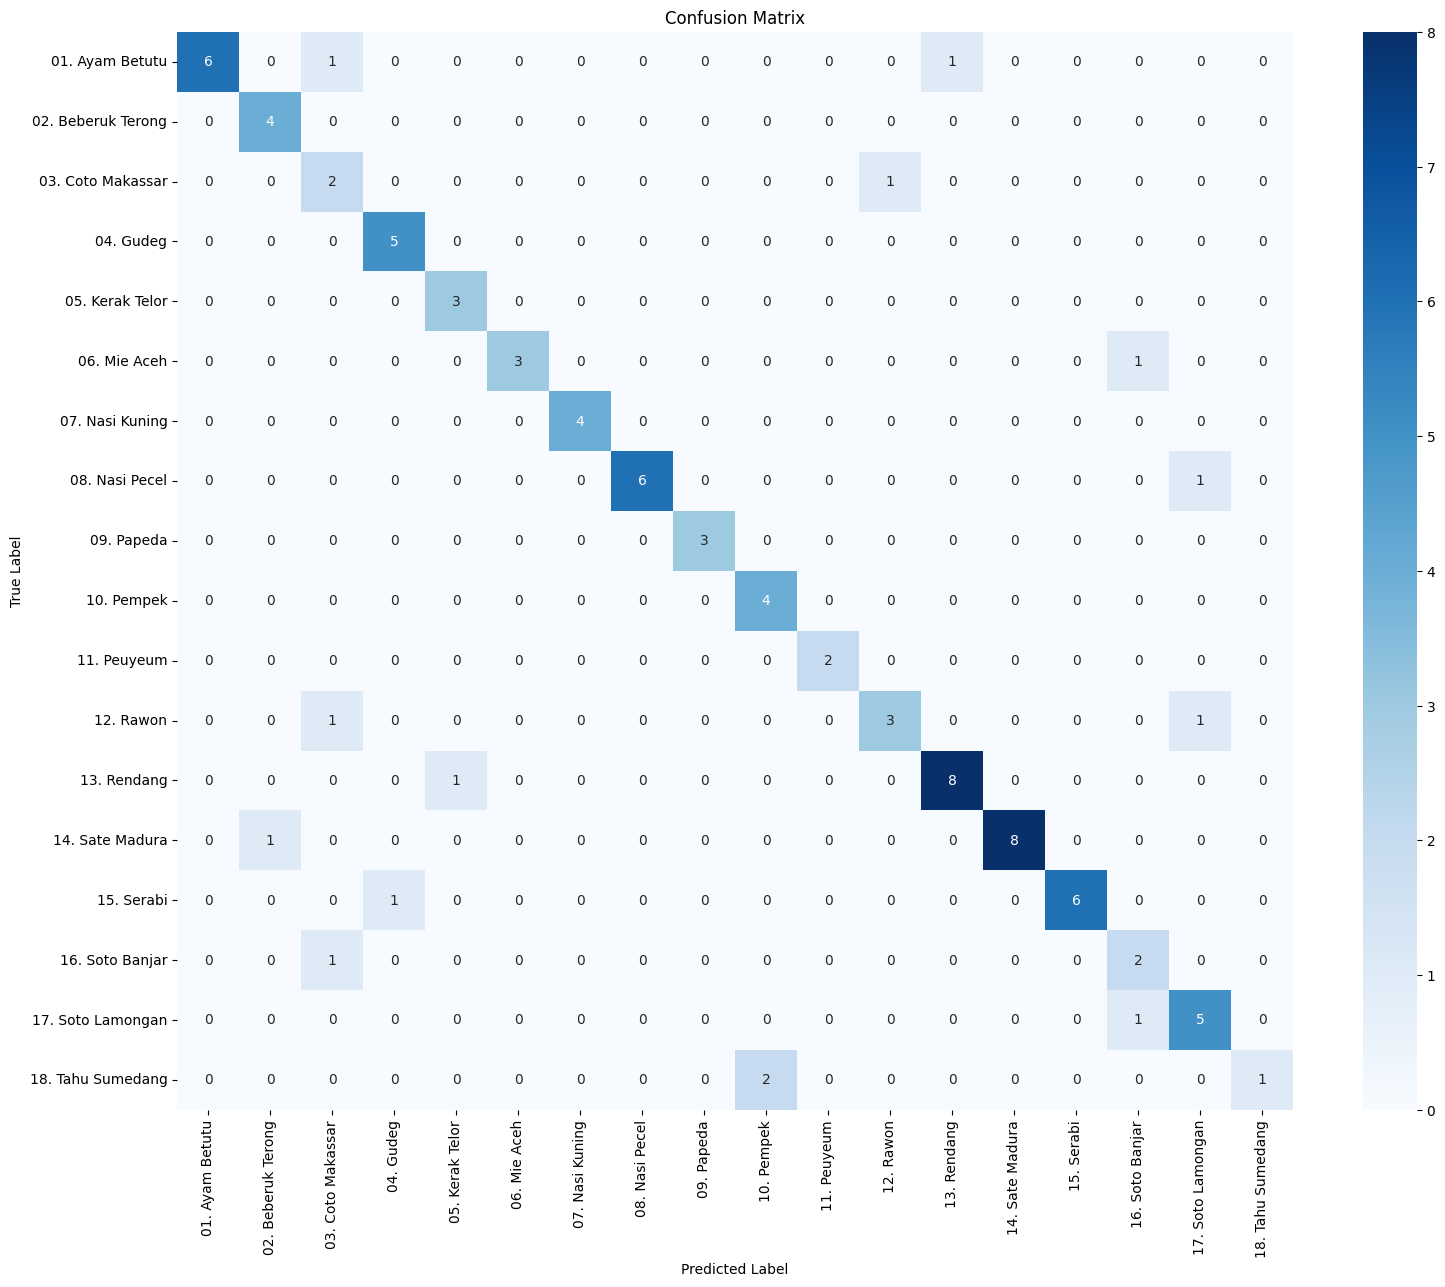

In [ ]:
# Sel 6: Evaluasi Model (Plot dan Metrik)

print("\nMemuat model terbaik untuk evaluasi (jika EarlyStopping digunakan dengan restore_best_weights=True)...")


# Plot Akurasi dan Loss Training & Validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_hist = history.history['loss'] # Ganti nama variabel 'loss' agar tidak bentrok dengan fungsi loss
val_loss_hist = history.history['val_loss'] # Ganti nama variabel 'val_loss'
epochs_ran = range(len(acc)) # Jumlah epoch yang benar-benar berjalan

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy')
plt.plot(epochs_ran, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss_hist, label='Training Loss')
plt.plot(epochs_ran, val_loss_hist, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Evaluasi pada Test Set
print("\nEvaluasi Model pada Test Set:")
# Pastikan generator test di-reset jika akan digunakan beberapa kali
test_generator.reset()
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps= (test_generator.samples + BATCH_SIZE - 1) // BATCH_SIZE, # Pastikan semua sampel ter-evaluasi
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi pada test set untuk Classification Report dan Confusion Matrix
print("\nMelakukan prediksi pada Test Set untuk laporan detail...")
test_generator.reset() # Reset lagi untuk konsistensi
predictions = model.predict(
    test_generator,
    steps= (test_generator.samples + BATCH_SIZE - 1) // BATCH_SIZE, # Pastikan semua sampel terprediksi
    verbose=1
)
predicted_classes_indices = np.argmax(predictions, axis=1)
true_classes_indices = test_generator.classes
if len(predicted_classes_indices) != len(true_classes_indices):
    print(f"Warning: Panjang prediksi ({len(predicted_classes_indices)}) tidak sama dengan label asli ({len(true_classes_indices)}). Menyesuaikan...")


print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(true_classes_indices, predicted_classes_indices, target_names=class_names, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes_indices, predicted_classes_indices)
plt.figure(figsize=(max(10, num_classes), max(8, int(num_classes*0.8)))) # Ukuran dinamis
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
final_model_path_h5 = '/content/model_klasifikasi_makanan_final.h5'
try:
    model.save(final_model_path_h5)
    print(f"\nModel final telah berhasil disimpan dalam format .h5 di: {final_model_path_h5}")
    print("Anda bisa mengunduhnya menggunakan sel kode di bawah.")
except Exception as e:
    print(f"Error saat menyimpan model: {e}")


Model final telah berhasil disimpan dalam format .h5 di: /content/model_klasifikasi_makanan_final.h5
Anda bisa mengunduhnya menggunakan sel kode di bawah.


In [ ]:
# Untuk mengunduh model yang disimpan, jalankan sel kode di bawah ini (di sel baru jika diinginkan)
from google.colab import files
files.download(final_model_path_h5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.preprocessing import image



def predict_single_image(img_path, loaded_model_to_use, target_img_width, target_img_height, class_labels_list):
    """Fungsi untuk memprediksi kelas dari satu gambar."""
    try:
        img = image.load_img(img_path, target_size=(target_img_width, target_img_height))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Buat batch (1, IMG_WIDTH, IMG_HEIGHT, 3)
        img_array /= 255.0 # Normalisasi, sesuaikan jika model Anda tidak menggunakan normalisasi ini

        prediction_probabilities = loaded_model_to_use.predict(img_array)
        predicted_class_index = np.argmax(prediction_probabilities[0])
        confidence = np.max(prediction_probabilities[0])
        predicted_class_name = class_labels_list[predicted_class_index]

        print(f"\nInformasi Gambar: {os.path.basename(img_path)}")
        print(f"Diprediksi sebagai: {predicted_class_name}")
        print(f"Confidence: {confidence:.2%}")

        # Tampilkan gambar dengan prediksinya
        plt.figure(figsize=(5,5))
        plt.imshow(img) # img sudah di-load oleh image.load_img
        plt.title(f"Prediksi: {predicted_class_name} ({confidence:.2%})")
        plt.axis('off')
        plt.show()

        return predicted_class_name, confidence, prediction_probabilities[0]

    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di '{img_path}'")
        return None, None, None
    except Exception as e:
        print(f"Error saat prediksi gambar: {e}")
        return None, None, None

print("\n--- Selesai ---")
print("Skrip telah dipecah menjadi beberapa sel.")
print("Jalankan setiap sel secara berurutan.")


--- Selesai ---
Skrip telah dipecah menjadi beberapa sel.
Jalankan setiap sel secara berurutan.


Menggunakan IMG_WIDTH: 150, IMG_HEIGHT: 150
Menggunakan class_names (total 18 kelas): ['01. Ayam Betutu', '02. Beberuk Terong', '03. Coto Makassar', '04. Gudeg', '05. Kerak Telor']...
Menggunakan model yang sudah ada di memori dari proses training sebelumnya.

Silakan unggah satu gambar makanan (.jpg atau .png) yang ingin Anda prediksi:


Saving hq720.jpg to hq720.jpg
Gambar 'hq720.jpg' telah diunggah dan akan diproses dari '/content/hq720.jpg'.

Melakukan prediksi pada gambar yang diunggah...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Informasi Gambar: hq720.jpg
Diprediksi sebagai: 13. Rendang
Confidence: 79.36%


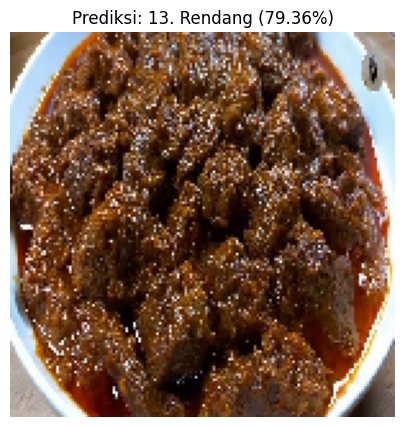


Hasil akhir dari fungsi prediksi:
Makanan: 13. Rendang
Tingkat Kepercayaan (Confidence): 79.36%


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files # Untuk mengunggah file
try:
    if IMG_WIDTH and IMG_HEIGHT and class_names:
        print(f"Menggunakan IMG_WIDTH: {IMG_WIDTH}, IMG_HEIGHT: {IMG_HEIGHT}")
        print(f"Menggunakan class_names (total {len(class_names)} kelas): {class_names[:5]}...") # Tampilkan 5 pertama
    else:
        raise NameError("Variabel tidak lengkap")
except NameError:
    print("PENTING: Variabel IMG_WIDTH, IMG_HEIGHT, atau class_names tidak ditemukan.")
    print("Harap pastikan Sel 3 (Persiapan Generator Data Gambar) sudah dijalankan dalam sesi ini,")
    print("atau definisikan variabel-variabel tersebut secara manual di bawah ini sebelum melanjutkan.")
    print("Contoh Manual (SESUAIKAN DENGAN DATASET ANDA):")
    # IMG_WIDTH, IMG_HEIGHT = 150, 150
    # class_names = ['ayam_betutu', 'ayam_goreng', ..., 'nama_kelas_ke_18'] # Ganti dengan daftar kelas Anda
    raise SystemExit("Hentikan eksekusi karena variabel penting tidak ada. Harap perbaiki.")


if 'predict_single_image' not in globals():
    print("Fungsi 'predict_single_image' belum terdefinisi. Harap jalankan sel yang mendefinisikannya (Sel 9) atau salin kodenya ke sini.")
    raise SystemExit("Fungsi prediksi tidak ditemukan.")


# --- 2. MUAT MODEL YANG SUDAH DILATIH ---
# Ganti path jika Anda menyimpannya dengan nama atau lokasi berbeda.
model_path_to_load = '/content/model_klasifikasi_makanan_final.h5'
loaded_model_for_prediction = None # Inisialisasi

try:
    # Cek apakah variabel 'model' dari training masih ada di memori dan valid
    if 'model' in locals() and isinstance(model, tf.keras.Model) and model.built:
        print("Menggunakan model yang sudah ada di memori dari proses training sebelumnya.")
        loaded_model_for_prediction = model
    # Jika tidak, coba muat dari file
    elif os.path.exists(model_path_to_load):
        print(f"Memuat model dari file: {model_path_to_load}...")
        loaded_model_for_prediction = load_model(model_path_to_load)
        print("Model berhasil dimuat dari file.")
    else:
        print(f"Error: File model '{model_path_to_load}' tidak ditemukan.")
        print("Pastikan model sudah dilatih, disimpan, dan path-nya benar.")
        raise FileNotFoundError("File model tidak ditemukan")
except Exception as e:
    print(f"Terjadi error saat mencoba mengakses atau memuat model: {e}")
    raise SystemExit("Gagal menyiapkan model untuk prediksi.")


# --- 3. UNGGAH GAMBAR YANG INGIN DIPREDIKSI ---
print("\nSilakan unggah satu gambar makanan (.jpg atau .png) yang ingin Anda prediksi:")
uploaded_test_images = files.upload() # Menggunakan jamak untuk menangani jika pengguna mengunggah >1

if not uploaded_test_images:
    print("Tidak ada gambar yang diunggah. Proses prediksi dibatalkan.")
else:
    # Ambil nama file dari gambar pertama yang diunggah
    new_image_filename = list(uploaded_test_images.keys())[0]
    new_image_path_colab = f'/content/{new_image_filename}' # Path gambar di Colab setelah diunggah
    print(f"Gambar '{new_image_filename}' telah diunggah dan akan diproses dari '{new_image_path_colab}'.")

    # --- 4. LAKUKAN PREDIKSI PADA GAMBAR YANG DIUNGGAH ---
    print("\nMelakukan prediksi pada gambar yang diunggah...")
    if loaded_model_for_prediction is not None:
        # Panggil fungsi prediksi
        predicted_name, confidence_score, probabilities = predict_single_image(
            new_image_path_colab,
            loaded_model_for_prediction,
            IMG_WIDTH,
            IMG_HEIGHT,
            class_names
        )

        if predicted_name is not None:
            print(f"\nHasil akhir dari fungsi prediksi:")
            print(f"Makanan: {predicted_name}")
            print(f"Tingkat Kepercayaan (Confidence): {confidence_score:.2%}")
        else:
            print("Prediksi gagal. Periksa pesan error di atas.")
    else:
        print("Tidak dapat melakukan prediksi karena model tidak berhasil dimuat atau disiapkan.")